<a href="https://colab.research.google.com/github/Dunckleosteus/seismic/blob/dominus/seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bruges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bruges
import bruges.filters as bf
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
!rm data.zip
!rm -r data
!wget https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
!unzip data.zip

rm: cannot remove 'data.zip': No such file or directory
rm: cannot remove 'data': No such file or directory
--2025-03-23 21:12:51--  https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip [following]
--2025-03-23 21:12:51--  https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512 (1.5K) [application/zip]
Saving to: ‘data.zip’

data.zip  

In [ ]:
df_path_list = [
    "data/rhob.csv",
    "data/vph.csv",
    "data/x.csv",
    "data/y.csv",
]
df_list = [pd.read_csv(path, index_col=None, header=None, sep=";") for path in df_path_list]
[df.dropna(inplace=True) for df in df_list]
for df in df_list:
  for col in df.columns:
    try:
      df[col] = df[col].str.replace(",", ".").astype(float).values
    except:
      df.values

array = np.stack(df_list)
array.shape

(4, 13, 31)

<ipython-input-4-0fed94de53ce>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


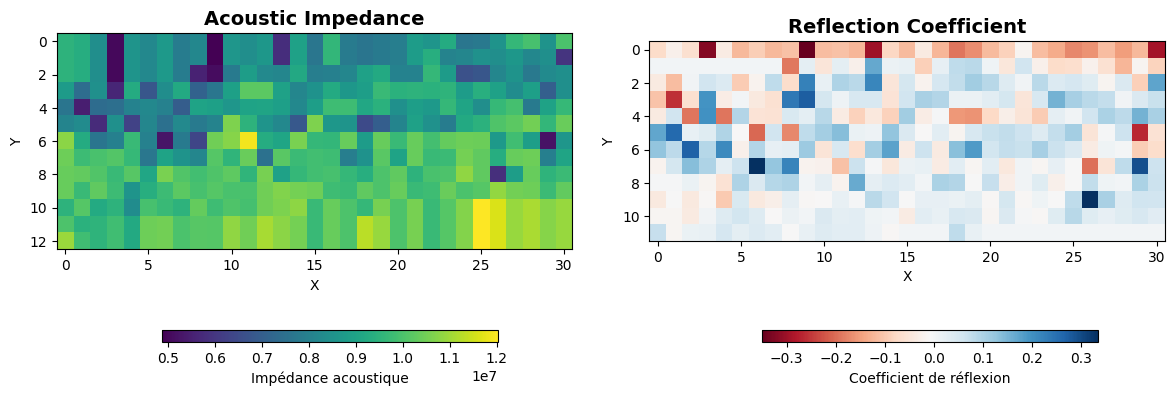

In [ ]:
#Conversion depth-time
TWT = (0.2 / array[1, :, :])
TWT = np.cumsum(TWT, axis=0) * 2 * 1000 #pour travailler en secondes

# Calcul de l'impédance acoustique
imp = array[0, :, :] * array[1, :, :]

# Calcul du coefficient de réflexion
I = np.roll(imp, shift=1, axis=0)[:-1, :]
In1 = imp[1:, :]
RC = (In1 - I) / (In1 + I)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(imp, cmap="viridis", interpolation="nearest")
axs[0].set_title("Acoustic Impedance", fontsize=14, fontweight="bold")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")

im2 = axs[1].imshow(RC, cmap="RdBu", interpolation="nearest")
axs[1].set_title("Reflection Coefficient", fontsize=14, fontweight="bold")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

cbar_ax1 = fig.add_axes([0.15, 0.225, 0.28, 0.02])
cbar_ax2 = fig.add_axes([0.65, 0.225, 0.28, 0.02])

fig.colorbar(im1, cax=cbar_ax1, orientation="horizontal", label="Impédance acoustique")
fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal", label="Coefficient de réflexion")

plt.tight_layout(rect=[0, 0.12, 1, 1])

plt.show()


In [ ]:
X = array[2, :, :]
Y = array[3, :, :]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Impédance acoustique en profondeur
sc1 = axs[0, 0].scatter(X, Y, c=imp, cmap='jet', marker='s', s=25)
axs[0, 0].set_title("Acoustic Impedance (Depth)")
axs[0, 0].set_xlabel("X")
axs[0, 0].set_ylabel("Y")
axs[0, 0].set_aspect(1)

# Coefficient de réflexion en profondeur
sc2 = axs[0, 1].scatter(X[:-1, :], Y[:-1, :], c=RC, cmap='binary', marker='s', s=25)
axs[0, 1].set_title("Reflection Coefficient Grid (Depth)")
axs[0, 1].set_xlabel("X")
axs[0, 1].set_ylabel("Y")
axs[0, 1].set_aspect(1)

# Impédance acoustique en temps (TWT)
sc3 = axs[1, 0].scatter(X, TWT, c=imp, cmap='jet', marker='o', s=25)
axs[1, 0].set_title("Acoustic Impedance (Time - TWT)")
axs[1, 0].set_xlabel("X")
axs[1, 0].set_ylabel("TWT (ms)")
axs[1, 0].invert_yaxis()

# Coefficient de réflexion en temps (TWT)
sc4 = axs[1, 1].scatter(X[:-1, :], TWT[:-1, :], c=RC, cmap='binary', marker='o', s=25)
axs[1, 1].set_title("Reflection Coefficient Grid (Time - TWT)")
axs[1, 1].set_xlabel("X")
axs[1, 1].set_ylabel("TWT (ms)")
axs[1, 1].invert_yaxis()

# Ajout des barres de couleurs uniformisées
cbar_ax1 = fig.add_axes([0.1, 0.62, 0.35, 0.02])  # Positionnement horizontal pour impédance
cbar_ax2 = fig.add_axes([0.6, 0.62, 0.35, 0.02])  # Positionnement horizontal pour réflexion


fig.colorbar(sc1, cax=cbar_ax1, orientation="horizontal", label="Impedance")
fig.colorbar(sc2, cax=cbar_ax2, orientation="horizontal", label="Reflection Coefficient")

plt.tight_layout()
plt.show()


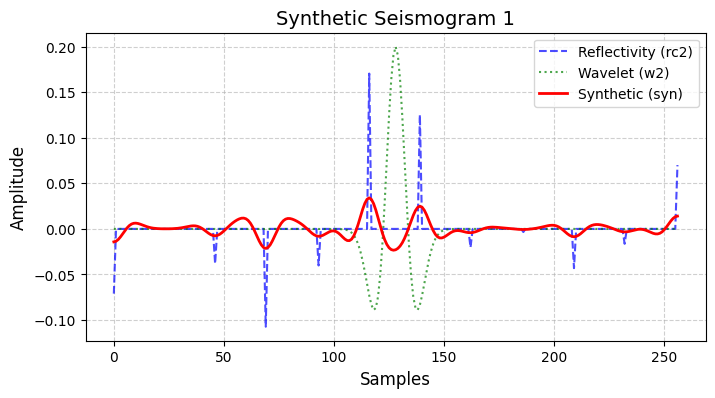

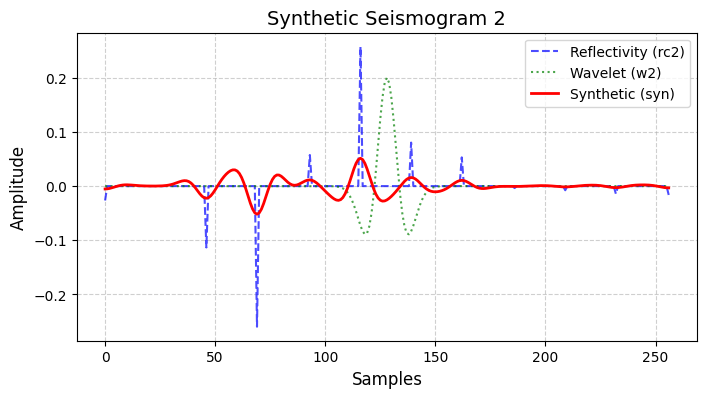

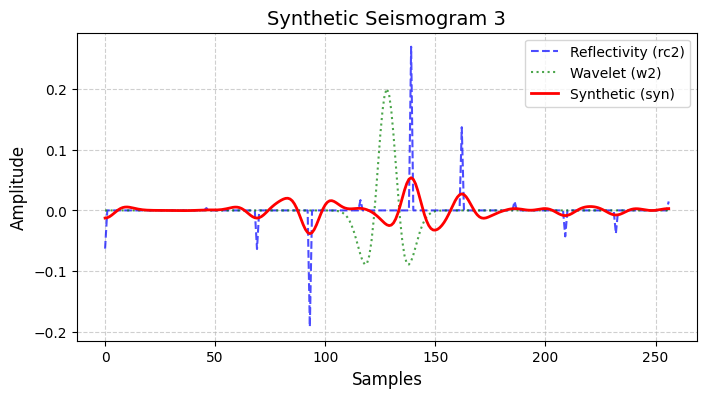

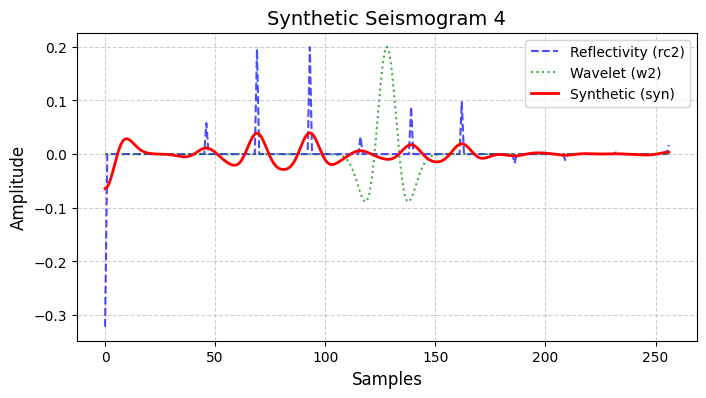

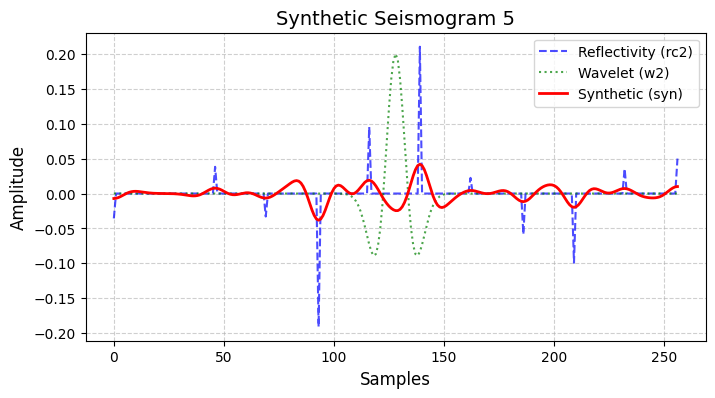

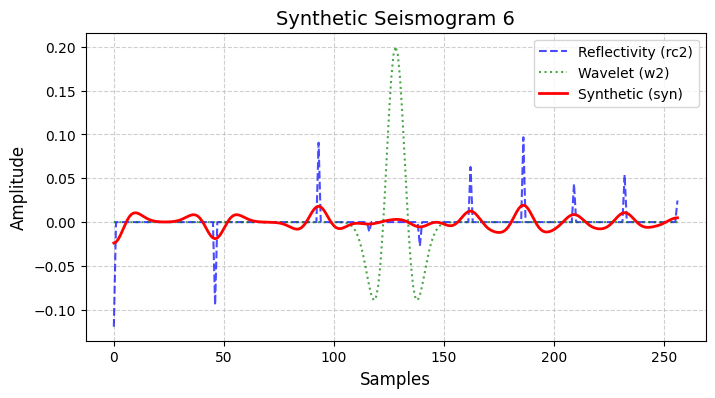

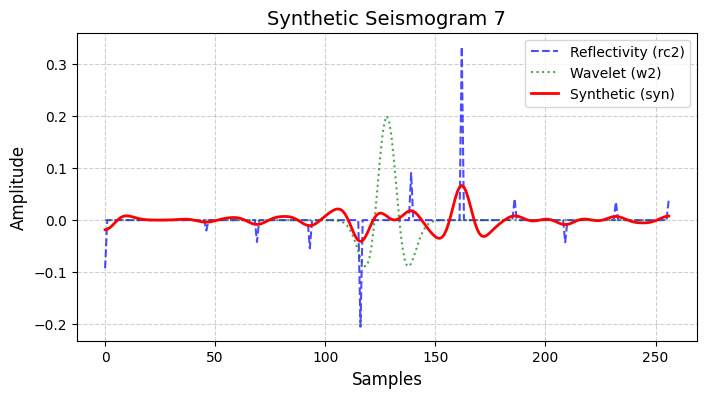

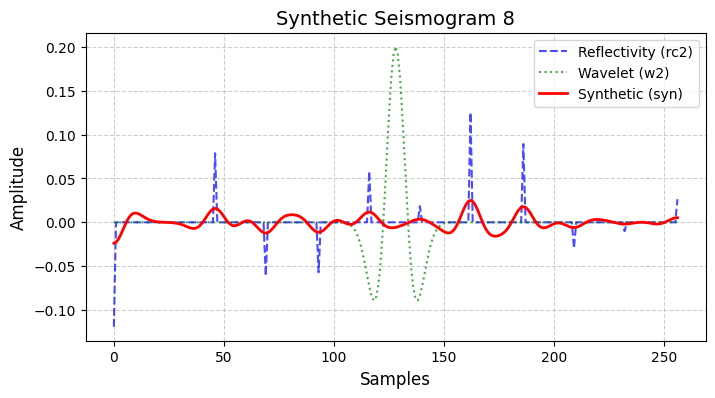

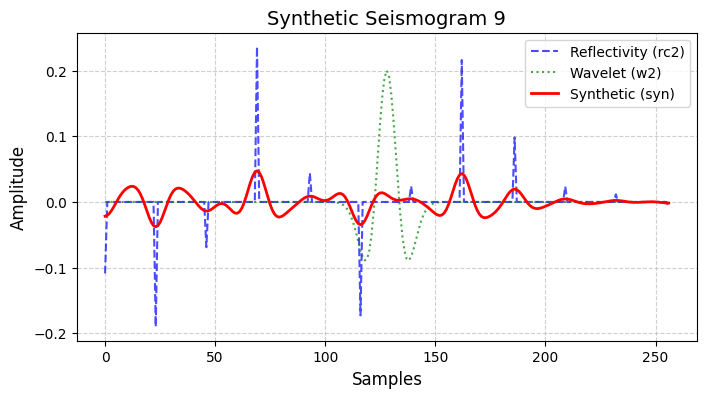

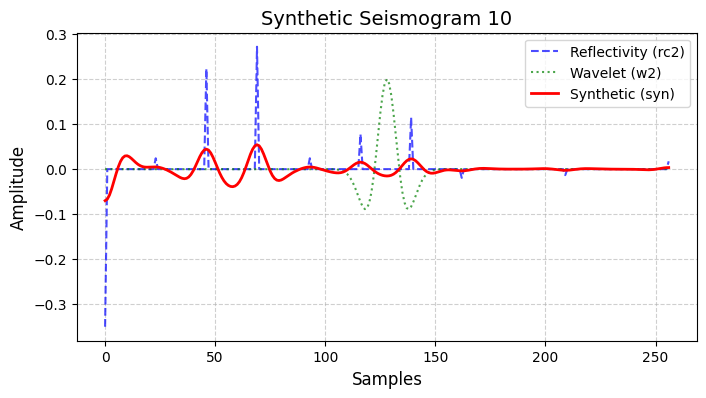

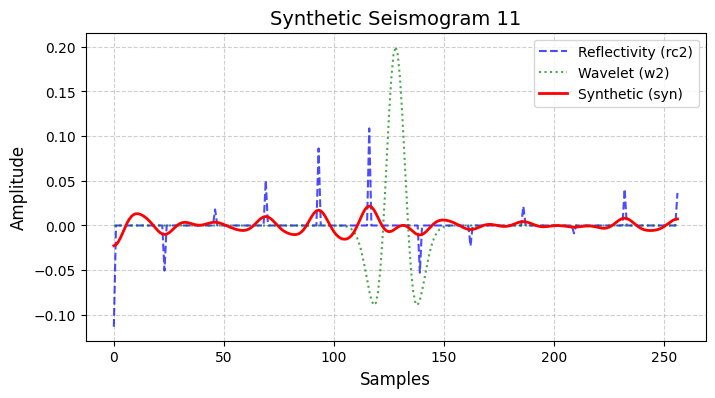

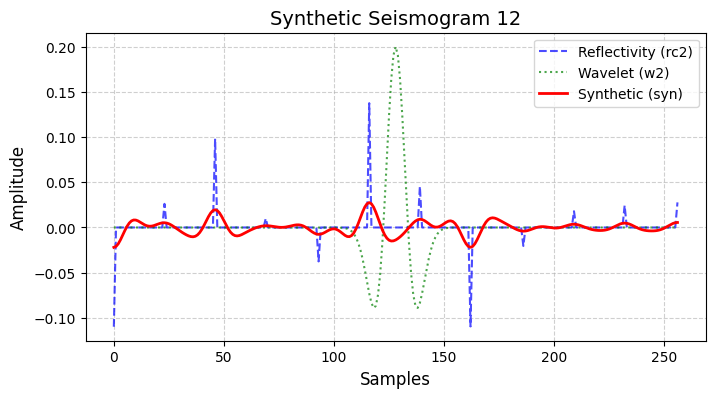

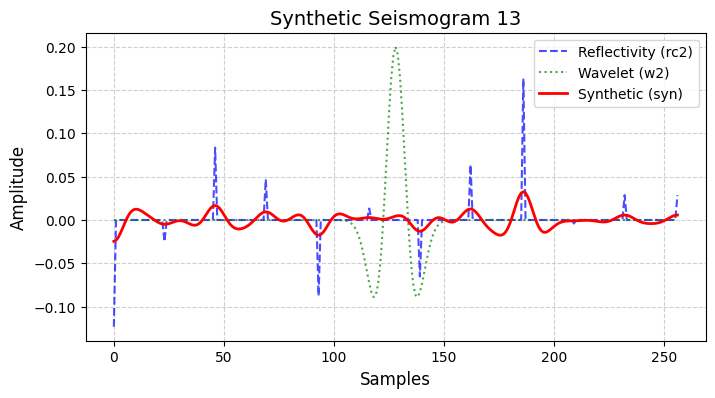

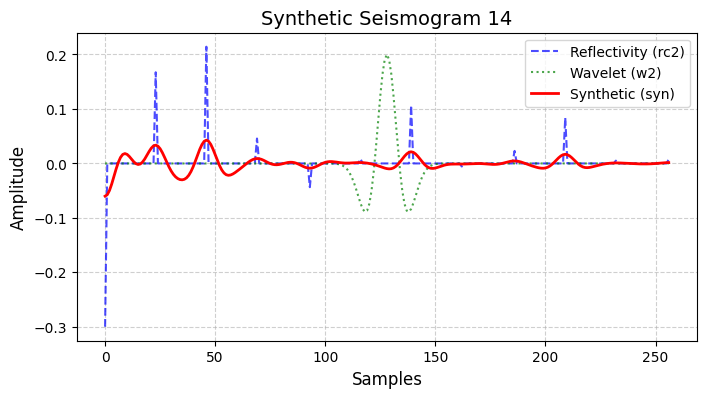

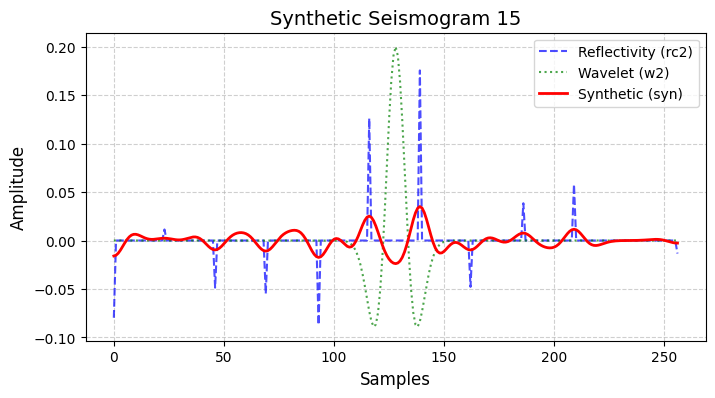

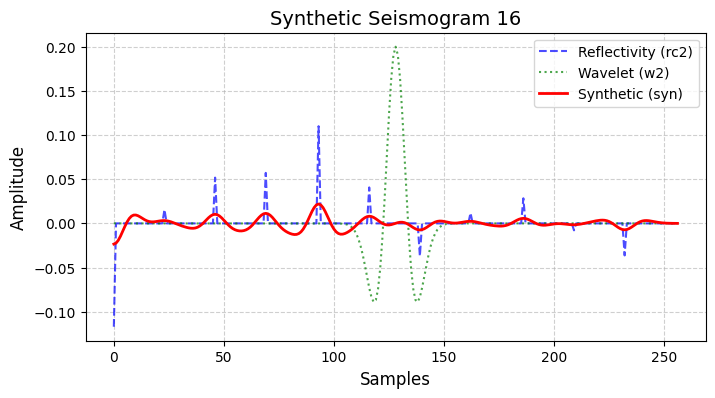

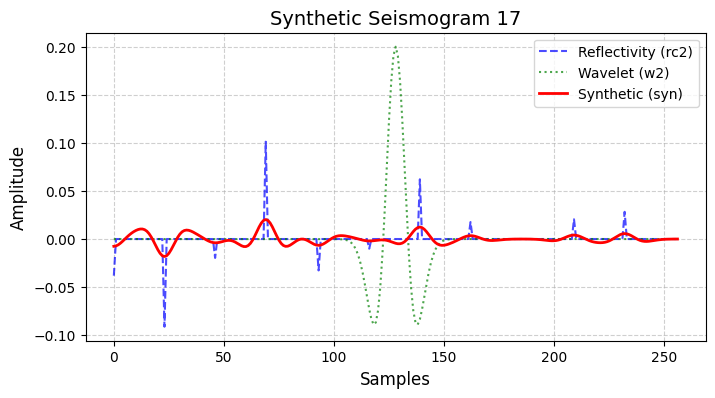

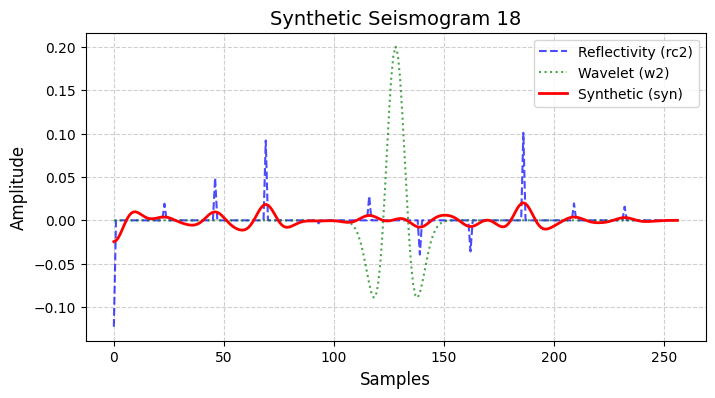

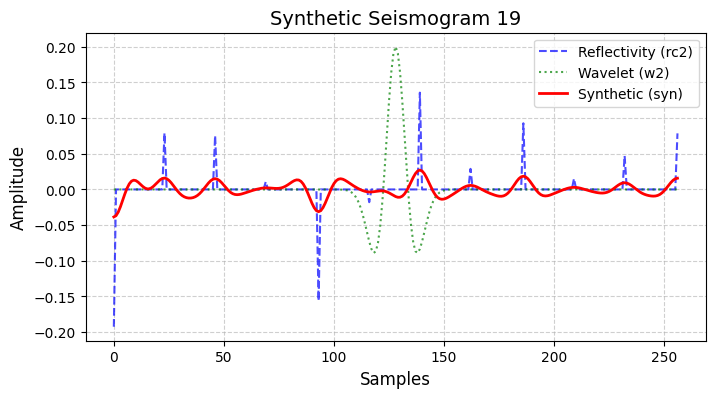

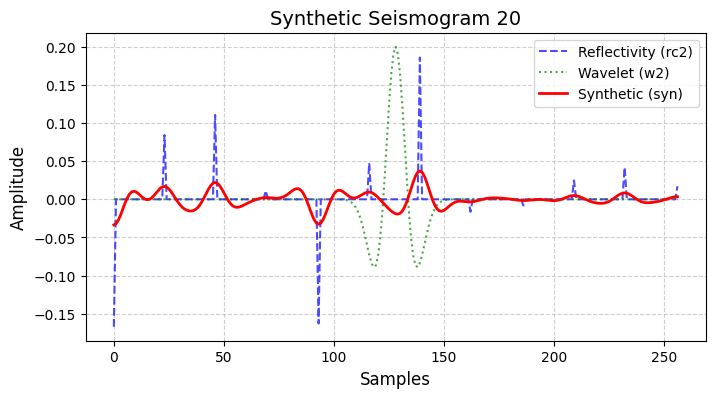

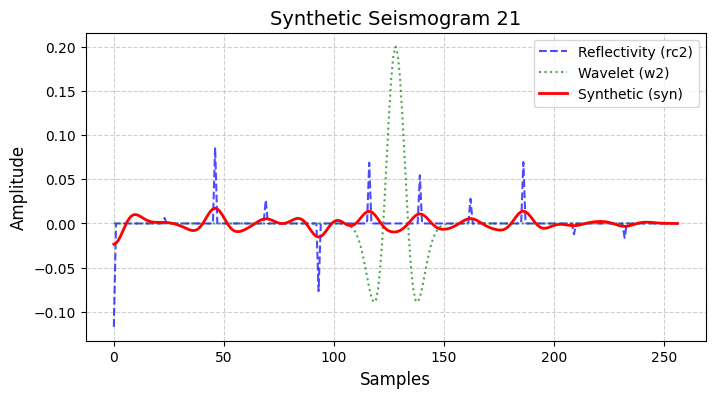

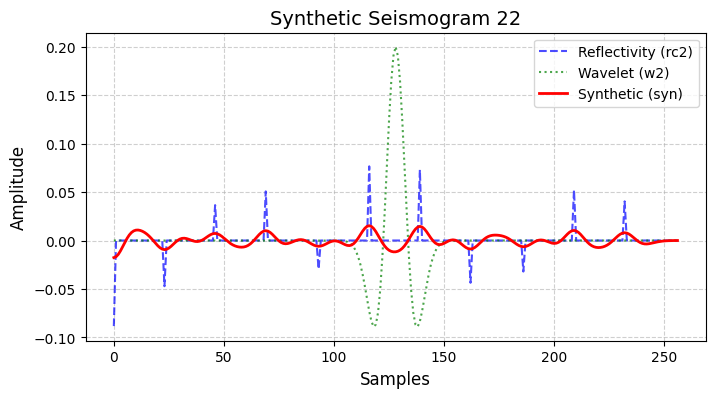

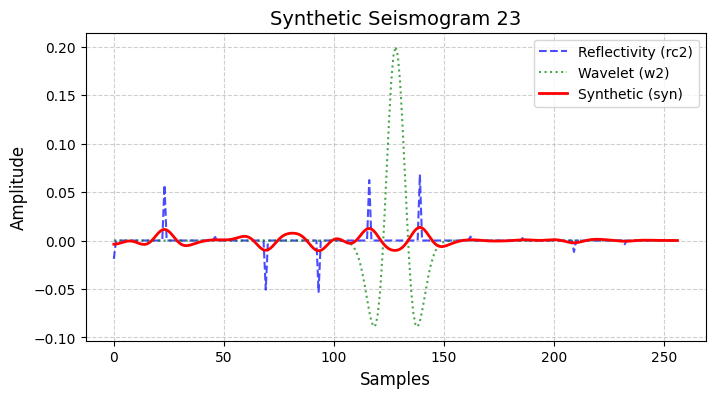

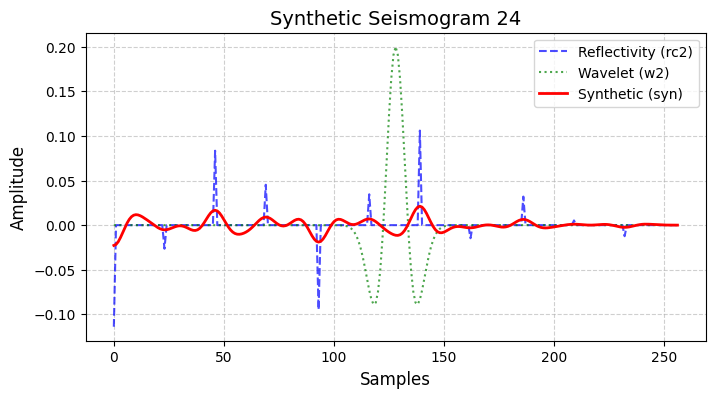

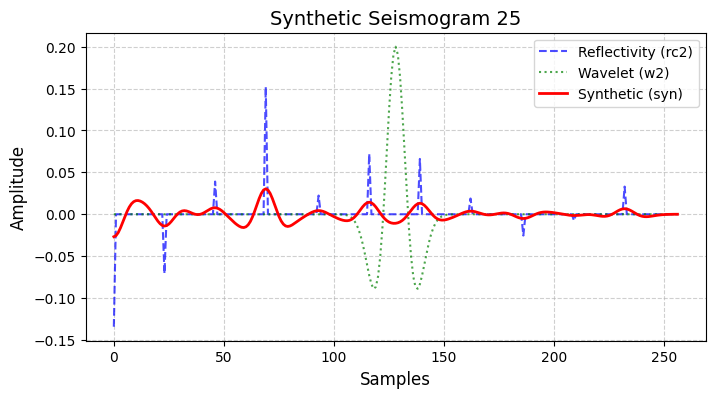

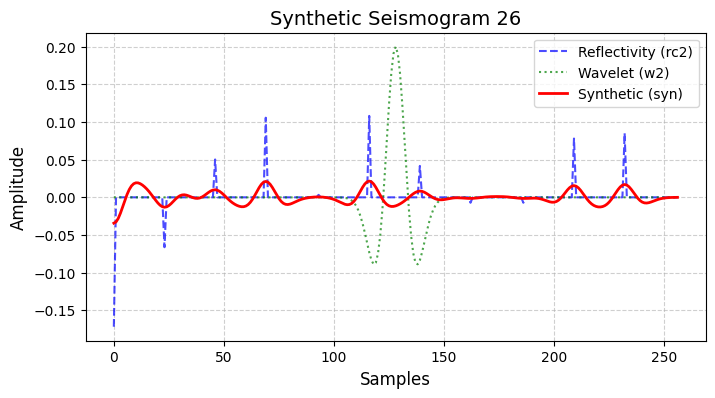

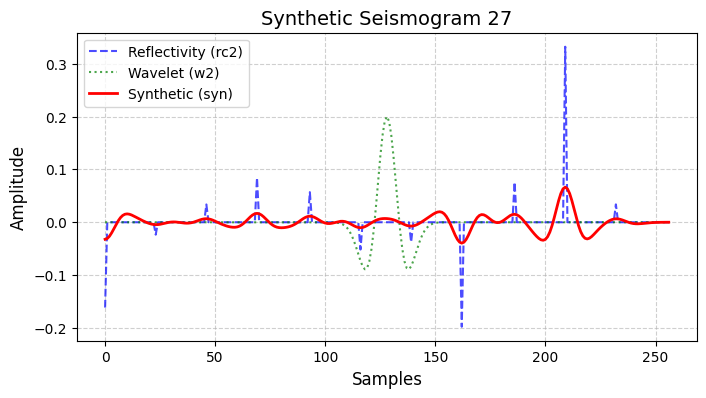

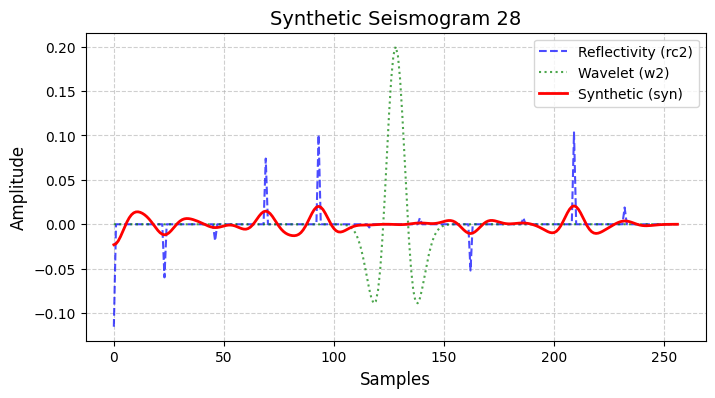

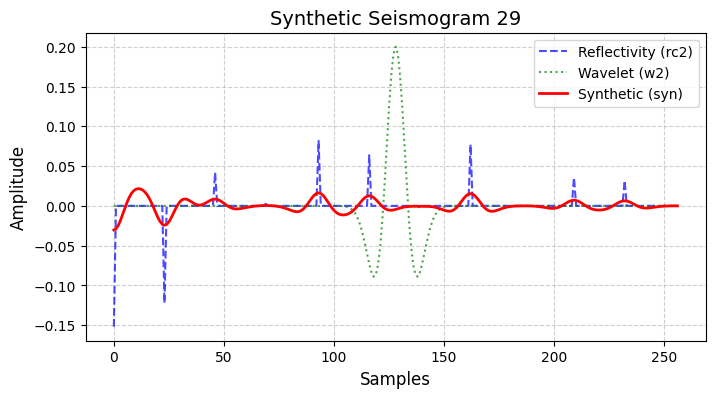

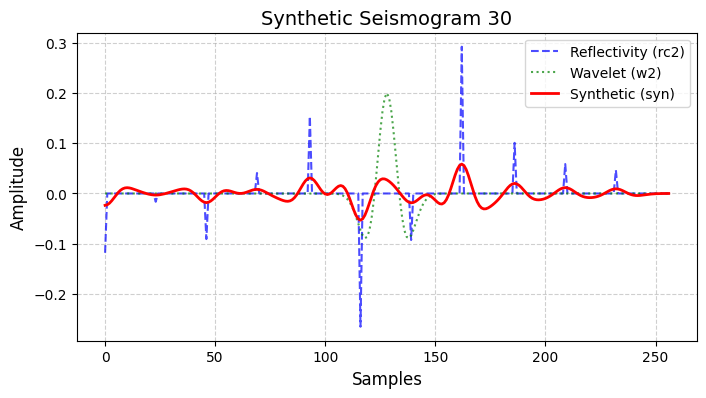

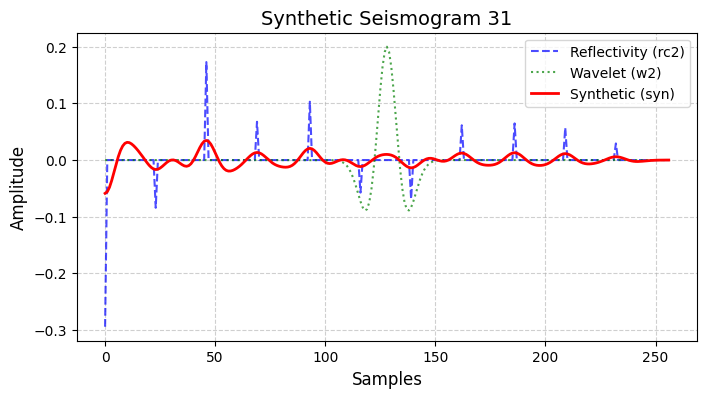

In [ ]:
rc = RC[1,:]
RC2 = np.transpose(RC)

traces = []
rc_list = []

x_values_list = []
amplitude_list = []
time_list = []

#Création d'une fonction pour créer une wavelet avec des paramètres utilisateurs
def create_wavelet(offset, amplitude, length=0.256, frequency=40, sample_intervall=0.01):
  w, t = bf.ricker(length, sample_intervall, frequency)
  t += offset
  w *= amplitude
  return w,t

w, t = create_wavelet(1.5, 0.2, sample_intervall=0.001)

#Fonction de pré-convolution
def expand_with_zeros(arr, target_length):
    if len(arr) == target_length:
        return arr
    new_arr = np.zeros(target_length)
    indices = np.linspace(0, target_length - 1, len(arr), dtype=int)
    for i, index in enumerate(indices):
        new_arr[index] = arr[i]
    return list(new_arr)

def equalize_arrays(arr1, arr2):
    max_length = max(len(arr1), len(arr2))

    arr1_expanded = expand_with_zeros(arr1, max_length)
    arr2_expanded = expand_with_zeros(arr2, max_length)

    return arr1_expanded, arr2_expanded

rc2, w2 = equalize_arrays(rc, w)

#version numpy
#Convolution

syn = np.convolve(rc2, w2, mode='same')

for i, rc in enumerate(RC2):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    plt.figure(figsize=(8, 4))

    plt.plot(rc2, label='Reflectivity (rc2)', color='b', linestyle='dashed', alpha=0.7)
    plt.plot(w2, label='Wavelet (w2)', color='g', linestyle='dotted', alpha=0.7)
    plt.plot(syn, label='Synthetic (syn)', color='r', linewidth=2)
    plt.title(f'Synthetic Seismogram {i+1}', fontsize=14)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

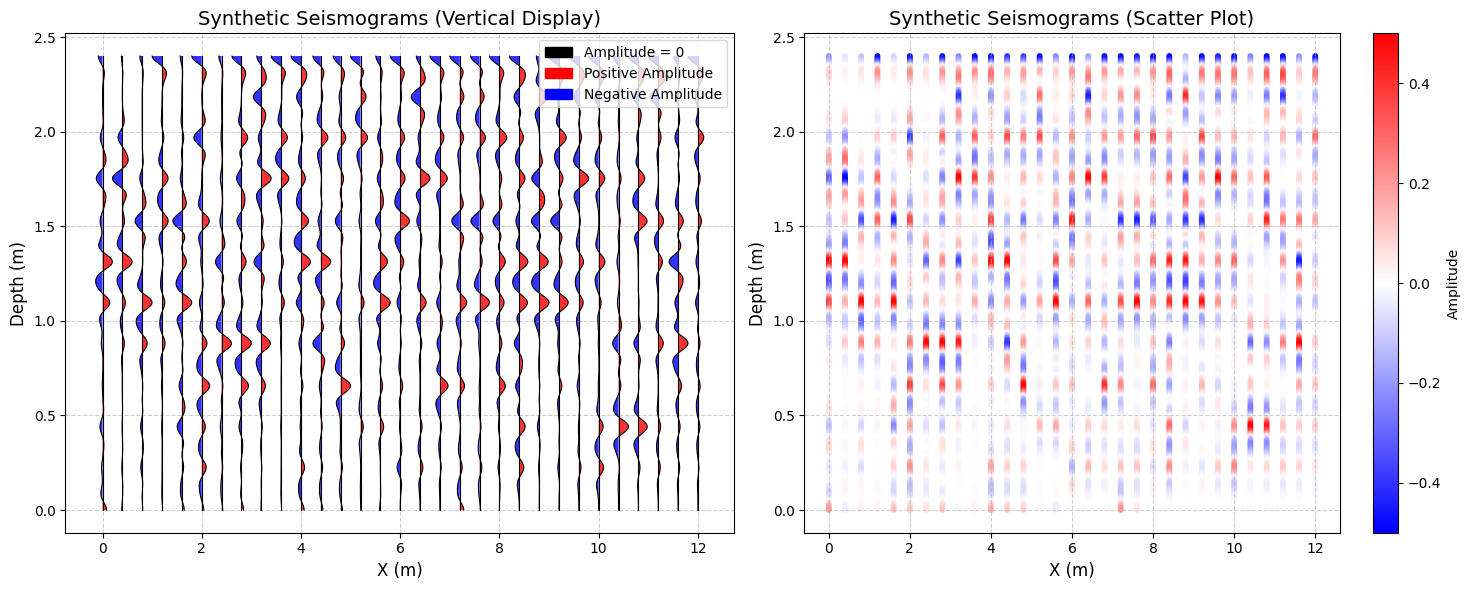

In [ ]:
#Plot vs Depth
x_values_list = []
amplitude_list = []
y_values_list = []
time_list = []

# Plot 1 : Synthetic Seismograms (Vertical Display)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, rc in enumerate(RC2):
    rc2, w2 = equalize_arrays(rc, w)
    syn = np.convolve(rc2, w2, mode='same')
    y_original = array[3, :, i]  # Utilisation des valeurs de Y
    time_original = TWT[:, i]  # Utilisation des valeurs de TWT

    if len(y_original) != len(rc2):
        f_y = interp1d(np.linspace(0, 1, len(y_original)), y_original, kind='linear', fill_value="extrapolate")
        y_resampled = f_y(np.linspace(0, 1, len(rc2)))
    else:
        y_resampled = y_original

    if len(time_original) != len(rc2):
        f_t = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f_t(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    syn_norm = syn / np.max(np.abs(syn)) * 0.5
    x_values = syn_norm + i

    for amp, y_val, t_val in zip(syn_norm, y_resampled, time_resampled):
        x_values_list.append(i)
        amplitude_list.append(amp)
        y_values_list.append(y_val)  # Ajouter y_resampled aux y_values_list
        time_list.append(t_val)

    x_values = x_values * 0.4
    i = i * 0.4

    axs[0].plot([i, i], [y_resampled[0], y_resampled[-1]], color='black', linewidth=0.8, label="Amplitude 0" if i == 0 else "")
    axs[0].plot(x_values, y_resampled, color='black', linewidth=0.8)
    axs[0].fill_betweenx(y_resampled, i, x_values, where=(syn_norm >= 0), facecolor='red', alpha=0.8, label="Positive Amplitude" if i == 0 else "")
    axs[0].fill_betweenx(y_resampled, i, x_values, where=(syn_norm < 0), facecolor='blue', alpha=0.8, label="Negative Amplitude" if i == 0 else "")

# Adjustments for Plot 1
axs[0].set_xlabel('X (m)', fontsize=12)
axs[0].set_ylabel('Depth (m)', fontsize=12)
axs[0].set_title('Synthetic Seismograms (Vertical Display)', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)

legend_patches = [
    mpatches.Patch(color='black', label='Amplitude = 0'),
    mpatches.Patch(color='red', label='Positive Amplitude'),
    mpatches.Patch(color='blue', label='Negative Amplitude')
]
axs[0].legend(handles=legend_patches, loc='upper right', fontsize=10, frameon=True)

# Conversion des arrays en DataFrame pour Plot 2
df = pd.DataFrame({
    'x': x_values_list,
    'amplitude': amplitude_list,
    'y': y_values_list,  # Utilisation de y_values_list pour les y_resampled
    'time': time_list
})

# Plot 2 : Scatter Plot
df['x'] = df['x'] * 0.4

sc = axs[1].scatter(df['x'], df['y'], c=df['amplitude'], cmap='bwr', marker='o', s=10)
cbar = plt.colorbar(sc, ax=axs[1])
cbar.set_label('Amplitude')

axs[1].set_xlabel('X (m)', fontsize=12)
axs[1].set_ylabel('Depth (m)', fontsize=12)
axs[1].set_title('Synthetic Seismograms (Scatter Plot)', fontsize=14)
#axs[1].invert_yaxis()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


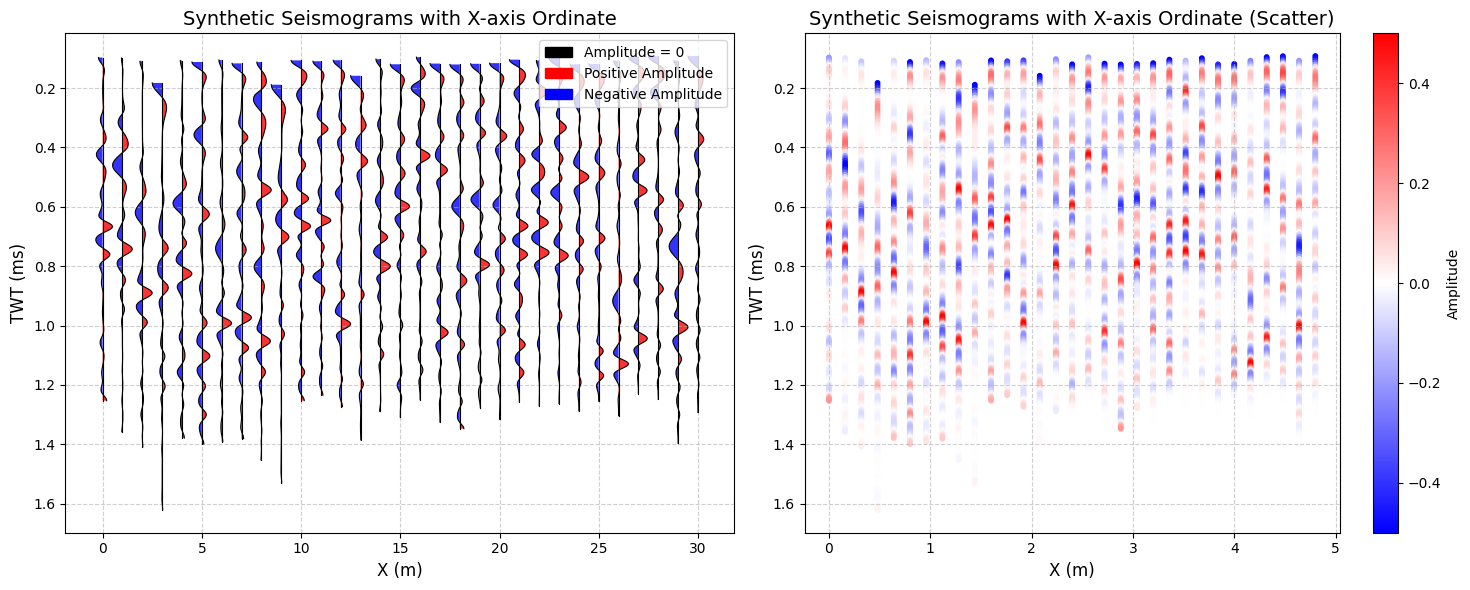

In [ ]:
#Plot vs TWT
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

x_values_list = []
amplitude_list = []
y_values_list = []
time_list = []

# Plot 3 with X as Ordinate
for i, rc in enumerate(RC2):
    rc2, w2 = equalize_arrays(rc, w)
    syn = np.convolve(rc2, w2, mode='same')
    time_original = TWT[:, i]

    if len(time_original) != len(rc2):
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    syn_norm = syn / np.max(np.abs(syn)) * 0.5
    x_values = syn_norm + i

    for amp, t in zip(syn_norm, time_resampled):
        x_values_list.append(i)
        amplitude_list.append(amp)
        time_list.append(t)



    axs[0].plot([i, i], [time_resampled[0], time_resampled[-1]], color='black', linewidth=0.8, label="Amplitude 0" if i == 0 else "")
    axs[0].plot(x_values, time_resampled, color='black', linewidth=0.8)
    axs[0].fill_betweenx(time_resampled, i, x_values, where=(syn_norm >= 0), facecolor='red', alpha=0.8, label="Positive Amplitude" if i == 0 else "")
    axs[0].fill_betweenx(time_resampled, i, x_values, where=(syn_norm < 0), facecolor='blue', alpha=0.8, label="Negative Amplitude" if i == 0 else "")

# Adjustments for Plot 3
axs[0].invert_yaxis()
axs[0].set_xlabel('X (m)', fontsize=12)
axs[0].set_ylabel('TWT (ms)', fontsize=12)
axs[0].set_title('Synthetic Seismograms with X-axis Ordinate', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend(handles=legend_patches, loc='upper right', fontsize=10, frameon=True)

df['x'] = df['x'] * 0.4

# Plot 4 : Scatter Plot with X as Ordinate
sc = axs[1].scatter(df['x'], df['time'], c=df['amplitude'], cmap='bwr', marker='o', s=10)
cbar = plt.colorbar(sc, ax=axs[1])
cbar.set_label('Amplitude')

axs[1].set_xlabel('X (m)', fontsize=12)
axs[1].set_ylabel('TWT (ms)', fontsize=12)
axs[1].set_title('Synthetic Seismograms with X-axis Ordinate (Scatter)', fontsize=14)
axs[1].invert_yaxis()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
